Reproduce Fig2 

In [49]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [50]:
fig_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fig_drafts\\'

### Get the data

In [55]:
results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\'

pfdl_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfdl\\acf\\' 
                                                    + 'acf_average_trial_pearsonr_with_empty_50ms_20lags_df.pkl')
pfp_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfp\\acf\\' 
                                                   + 'acf_average_trial_pearsonr_with_empty_50ms_20lags_df.pkl')

pfdl_acf_average_trial_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfdl\\acf\\' 
                                                + 'acf_average_trial_sttc_with_empty_50ms_20lags_51padding_df.pkl')
pfp_acf_average_trial_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfp\\acf\\' 
                                               + 'acf_average_trial_sttc_with_empty_50ms_20lags_51padding_df.pkl')

pfdl_dataset_constraints_df = pd.read_pickle(results_folder + 'pfdl_dataset_constraints_df.pkl')
pfp_dataset_constraints_df = pd.read_pickle(results_folder + 'pfp_dataset_constraints_df.pkl')

# get subset 

pfdl_dataset_constraints_subset_df = pfdl_dataset_constraints_df.query('n_trials_more_20 == True and no_zero_bins == 1 and one_hz_activity == 1').copy()
pfp_dataset_constraints_subset_df = pfp_dataset_constraints_df.query('n_trials_more_20 == True and no_zero_bins == 1 and one_hz_activity == 1').copy()

# join
pfdl_acf_average_trial_pearsonr_subset_df = pfdl_dataset_constraints_subset_df.merge(pfdl_acf_average_trial_pearsonr_df, 
                                                                              on='unit_id', how='left')
pfp_acf_average_trial_pearsonr_subset_df = pfp_dataset_constraints_subset_df.merge(pfp_acf_average_trial_pearsonr_df, 
                                                                              on='unit_id', how='left')

pfdl_acf_average_trial_sttc_subset_df = pfdl_dataset_constraints_subset_df.merge(pfdl_acf_average_trial_sttc_df, 
                                                                              on='unit_id', how='left')
pfp_acf_average_trial_sttc_subset_df = pfp_dataset_constraints_subset_df.merge(pfp_acf_average_trial_sttc_df, 
                                                                              on='unit_id', how='left')

# pfdl_included_units_l = pfdl_constrained_data_acf_binned_1000_df.query('n_trials_more_20 == True and no_zero_bins == 1 and one_hz_activity == 1')['unit_id'].values
# pfdl_acf_average_trial_sttc_df = pfdl_acf_average_trial_sttc_df_[pfdl_acf_average_trial_sttc_df_['unit_id'].isin(pfdl_included_units_l)].copy()
# pfdl_acf_average_trial_sttc_df.reset_index(inplace=True, drop=True)

# pfp_included_units_l = pfp_constrained_data_acf_binned_1000_df.query('n_trials_more_20 == True and no_zero_bins == 1 and one_hz_activity == 1')['unit_id'].values
# pfp_acf_average_trial_sttc_df = pfp_acf_average_trial_sttc_df_[pfp_acf_average_trial_sttc_df_['unit_id'].isin(pfp_included_units_l)].copy()
# pfp_acf_average_trial_sttc_df.reset_index(inplace=True, drop=True)

# print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_acf_average_trial_pearsonr_df), len(pfp_acf_average_trial_pearsonr_df)))
# print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_acf_average_trial_sttc_df), len(pfp_acf_average_trial_sttc_df)))

# print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_pearsonr_df.isnull().any().any()))
# print('NaNs in PFp acf {}'.format(pfp_acf_average_trial_pearsonr_df.isnull().any().any()))

# print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_sttc_df.isnull().any().any()))
# print('NaNs in PFp acf {}'.format(pfp_acf_average_trial_sttc_df.isnull().any().any()))

In [56]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags)]

pfdl_acf_2d = pfdl_acf_average_trial_pearsonr_subset_df[acf_cols].values
pfp_acf_2d = pfp_acf_average_trial_pearsonr_subset_df[acf_cols].values

pfdl_acf_mean = np.nanmean(pfdl_acf_2d, axis=0)
pfdl_acf_sem = stats.sem(pfdl_acf_2d, axis=0)
pfp_acf_mean = np.nanmean(pfp_acf_2d, axis=0)
pfp_acf_sem = stats.sem(pfp_acf_2d, axis=0)

pfdl_acf_sttc_2d = pfdl_acf_average_trial_sttc_subset_df[acf_cols].values
pfp_acf_sttc_2d = pfp_acf_average_trial_sttc_subset_df[acf_cols].values

pfdl_acf_sttc_mean = np.nanmean(pfdl_acf_sttc_2d, axis=0)
pfdl_acf_sttc_sem = stats.sem(pfdl_acf_sttc_2d, axis=0)
pfp_acf_sttc_mean = np.nanmean(pfp_acf_sttc_2d, axis=0)
pfp_acf_sttc_sem = stats.sem(pfp_acf_sttc_2d, axis=0)

### Calculate tau

In [27]:
def func_single_exp(x, a, b, c):
    """
    Exponential function to fit the data.
    :param x: 1d array, independent variable
    :param a: float, parameter to fit
    :param b: float, parameter to fit
    :param c: float, parameter to fit
    :return: callable
    """
    #return a * np.exp(-b * x) + c
    return a * (np.exp(-b * x) + c) # as in the paper

In [9]:
def calc_tau_area_mean(acf_mean_, start_idx_=1):    
    t = np.linspace(0, len(acf_mean_)-1, len(acf_mean_)).astype(int)
    # print(t)
    
    popt, pcov = curve_fit(func_single_exp, t[start_idx_:], acf_mean_[start_idx_:], maxfev=1000000000) # I used 5000, now it is like in Siegle
    tau = 1 / popt[1]
    
    # fit r-squared
    y_pred = func_single_exp(t[start_idx_:], *popt)
    fit_r_squared = r2_score(acf_mean_[start_idx_:], y_pred)

    return tau, popt, fit_r_squared

In [53]:
pfdl_tau, pfdl_popt, pfdl_fit_r_squared = calc_tau_area_mean(pfdl_acf_mean, start_idx_=2)
pfdl_tau_ms = pfdl_tau*50
print('pfdl_tau {}, pfdl_popt {}, pfdl_fit_r_squared {}'.format(pfdl_tau_ms, pfdl_popt, pfdl_fit_r_squared))

pfp_tau, pfp_popt, pfp_fit_r_squared = calc_tau_area_mean(pfp_acf_mean, start_idx_=2)
pfp_tau_ms = pfp_tau*50
print('pfp_tau {}, pfp_popt {}, pfp_fit_r_squared {}'.format(pfp_tau_ms, pfp_popt, pfp_fit_r_squared))

pfdl_tau 244.66385434766593, pfdl_popt [0.23784214 0.20436202 0.15879459], pfdl_fit_r_squared 0.9969624870385067
pfp_tau 237.0835616466337, pfp_popt [0.19593383 0.21089611 0.20724523], pfp_fit_r_squared 0.9956847528944458


In [57]:
pfdl_sttc_tau, pfdl_sttc_popt, pfdl_sttc_fit_r_squared = calc_tau_area_mean(pfdl_acf_sttc_mean, start_idx_=2)
pfdl_sttc_tau_ms = pfdl_sttc_tau*50
print('pfdl_sttc_tau {}, pfdl_sttc_popt {}, pfdl_sttc_fit_r_squared {}'.format(pfdl_sttc_tau_ms, pfdl_sttc_popt, pfdl_sttc_fit_r_squared))

pfp_sttc_tau, pfp_sttc_popt, pfp_sttc_fit_r_squared = calc_tau_area_mean(pfp_acf_sttc_mean, start_idx_=2)
pfp_sttc_tau_ms = pfp_sttc_tau*50
print('pfp_sttc_tau {}, pfp_sttc_popt {}, pfp_sttc_fit_r_squared {}'.format(pfp_sttc_tau_ms, pfp_sttc_popt, pfp_sttc_fit_r_squared))

pfdl_sttc_tau 236.46721453379206, pfdl_sttc_popt [0.16663934 0.2114458  0.21191084], pfdl_sttc_fit_r_squared 0.9900719471385668
pfp_sttc_tau 235.77131965979373, pfp_sttc_popt [0.14041554 0.2120699  0.25229446], pfp_sttc_fit_r_squared 0.9935120666600473


### Plot

In [30]:
save_fig = False

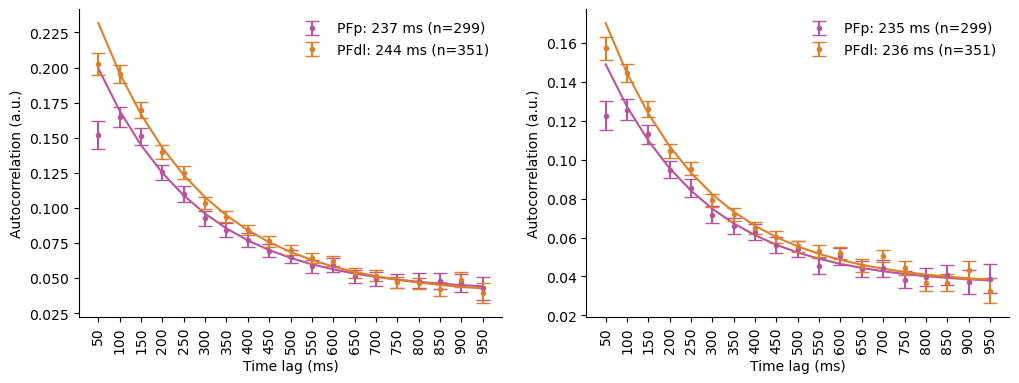

In [58]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=False)

t = np.linspace(1, n_lags-1, n_lags-1).astype(int)
t_labels = np.linspace(50, 950, n_lags-1).astype(int)

pfp_label = 'PFp: ' + str(int(pfp_tau_ms)) + ' ms (n=' + str(len(pfp_acf_average_trial_pearsonr_subset_df)) + ')'
axes[0].errorbar(t, pfp_acf_mean[1:], pfp_acf_sem[1:], linestyle='None', marker='.', capsize=5, color='#b8549b', label=pfp_label)
axes[0].plot(t, func_single_exp(t, pfp_popt[0], pfp_popt[1], pfp_popt[2]), color='#b8549b')

pfdl_label = 'PFdl: ' + str(int(pfdl_tau_ms)) + ' ms (n=' + str(len(pfdl_acf_average_trial_pearsonr_subset_df)) + ')'
axes[0].errorbar(t, pfdl_acf_mean[1:], pfdl_acf_sem[1:], linestyle='None', marker='.', capsize=5, color='#dd7f28', label=pfdl_label)
axes[0].plot(t, func_single_exp(t, pfdl_popt[0], pfdl_popt[1], pfdl_popt[2]), color='#dd7f28', )


pfp_label = 'PFp: ' + str(int(pfp_sttc_tau_ms)) + ' ms (n=' + str(len(pfp_acf_average_trial_sttc_subset_df)) + ')'
axes[1].errorbar(t, pfp_acf_sttc_mean[1:], pfp_acf_sttc_sem[1:], linestyle='None', marker='.', capsize=5, color='#b8549b', label=pfp_label)
axes[1].plot(t, func_single_exp(t, pfp_sttc_popt[0], pfp_sttc_popt[1], pfp_sttc_popt[2]), color='#b8549b')

pfdl_label = 'PFdl: ' + str(int(pfdl_sttc_tau_ms)) + ' ms (n=' + str(len(pfdl_acf_average_trial_sttc_subset_df)) + ')'
axes[1].errorbar(t, pfdl_acf_sttc_mean[1:], pfdl_acf_sttc_sem[1:], linestyle='None', marker='.', capsize=5, color='#dd7f28', label=pfdl_label)
axes[1].plot(t, func_single_exp(t, pfdl_sttc_popt[0], pfdl_sttc_popt[1], pfdl_sttc_popt[2]), color='#dd7f28', )

#axes.set_ylim([0, 0.25])

for ax in axes.flat:
    ax.set_xticks(t)
    ax.set_xticklabels(t_labels, rotation=90)
    ax.set_xlabel('Time lag (ms)')
    ax.set_ylabel('Autocorrelation (a.u.)')  
    
    ax.legend(frameon=False)

sns.despine()

if save_fig:
    fig.savefig(fig_folder + 'fig2_repr_pearson_and_sttc.png', bbox_inches='tight')
    fig.savefig(fig_folder + 'fig2_repr_pearson_and_sttc.svg', bbox_inches='tight')